In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [275]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
#from keras.utils.vis_utils import plot_model, model_to_dot
from tensorflow.keras.utils import plot_model
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(48) # Data reproducibility
tf.config.experimental.enable_op_determinism()

In [ ]:
df = pd.read_csv('Sunspots.csv')
df = df[['Monthly Mean Total Sunspot Number']]
df.head()

,Monthly Mean Total Sunspot Number
0,96.7
1,104.3
2,116.7
3,92.8
4,141.7


In [277]:
df1 = df.to_numpy()

In [278]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)
X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1),label_col=1, train_len=16, test_len=1)
print(X_in.shape, X_out.shape)

(3249, 16, 1) (3249, 1, 1)


In [279]:
train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(2274, 16, 1) (2274, 1, 1) (975, 16, 1) (975, 1, 1)


In [280]:
r=0.5 # confidence {0-1}
q = 0.95
delta = 0.002# 0.05,0.1

def confidance_loss(y_true,y_pred):
  y_true = y_true[:,0]
  f1 = y_pred[:,0]
  f2 = y_pred[:,1]

  c1 = (1-q)*(y_true-f2)
  c2 = (1-q)*(f1-y_true)
  c3 = q*(f2-y_true)
  c4 = q*(y_true-f1)

  loss = K.switch(tf.math.logical_and((y_true <= f1),(y_true>=f2)),K.switch((y_true>r*(f1+f2)),c1,c2),K.switch((f2>y_true),c3,c4)) + (delta * tf.math.abs(f1-f2))

  return loss

In [281]:
input_train = Input(shape=(16, 1))
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lstm_l1 = LSTM(256, activation='relu',kernel_initializer=initializer,return_sequences=True)(input_train)
dp_l1 = Dropout(0.3)(lstm_l1)
lstm_l2 = LSTM(128, activation='relu',kernel_initializer=initializer,return_sequences=False)(dp_l1)
dp_l2 = Dropout(0.2)(lstm_l2)
# lstm_l3 = LSTM(128, activation='relu',kernel_initializer=initializer,return_sequences=False)(dp_l1)
# dp_l3 = Dropout(0.1)(lstm_l3)
out = Dense(2)(dp_l2)
model = Model(inputs=input_train, outputs=out)

c:\Users\aades\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [282]:
opt = Adam(learning_rate=0.001)
model.compile(loss=confidance_loss,optimizer=opt)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 16, 1)]           0         
                                                                 
 lstm_53 (LSTM)              (None, 16, 256)           264192    
                                                                 
 dropout_51 (Dropout)        (None, 16, 256)           0         
                                                                 
 lstm_54 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 258       
                                                                 
Total params: 461570 (1.76 MB)
Trainable params: 461570 (1

In [283]:
epc = 300
start_time = datetime.datetime.now()
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
history = model.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=64)
end_time = datetime.datetime.now()
total_time = end_time - start_time
print('seconds taken:', round(total_time.total_seconds(),1),
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
32/32 [==============================] - 5s 96ms/step - loss: 12.5862 - val_loss: 7.0801
Epoch 2/300
32/32 [==============================] - 3s 88ms/step - loss: 8.7559 - val_loss: 6.8148
Epoch 3/300
32/32 [==============================] - 3s 89ms/step - loss: 7.6571 - val_loss: 4.5942
Epoch 4/300
32/32 [==============================] - 3s 89ms/step - loss: 7.2653 - val_loss: 5.2801
Epoch 5/300
32/32 [==============================] - 3s 89ms/step - loss: 6.0976 - val_loss: 4.5137
Epoch 6/300
32/32 [==============================] - 3s 91ms/step - loss: 6.1528 - val_loss: 5.0196
Epoch 7/300
32/32 [==============================] - 3s 93ms/step - loss: 6.2313 - val_loss: 4.7973
Epoch 8/300
32/32 [==============================] - 3s 93ms/step - loss: 6.2282 - val_loss: 4.4503
Epoch 9/300
32/32 [==============================] - 3s 93ms/step - loss: 5.9433 - val_loss: 4.5147
Epoch 10/300
32/32 [==============================] - 3s 92ms/step - loss: 5.7357 - val_loss: 5.010

In [284]:
y_pred = model.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y)  # Actual test values
y_u_pred = y_pred[:, 0]  # Upper bound predictions
y_l_pred = y_pred[:, 1]  # Lower bound predictions

K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_

print(f'PICP: {np.mean(K_u * K_l)}')
print(f'MPIW: {np.round(np.mean(y_u_pred - y_l_pred), 3)}')


PICP: 0.9517948717948718
MPIW: 101.20500183105469


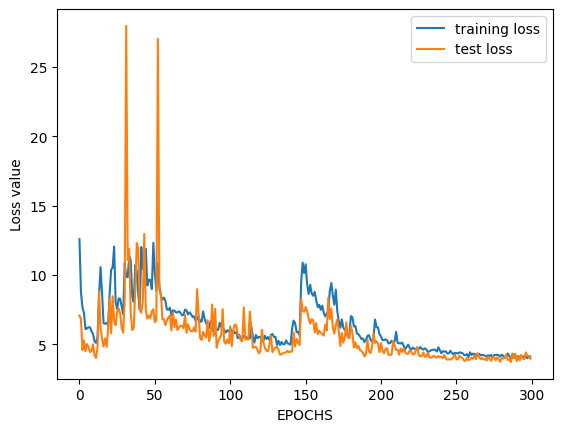

In [285]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

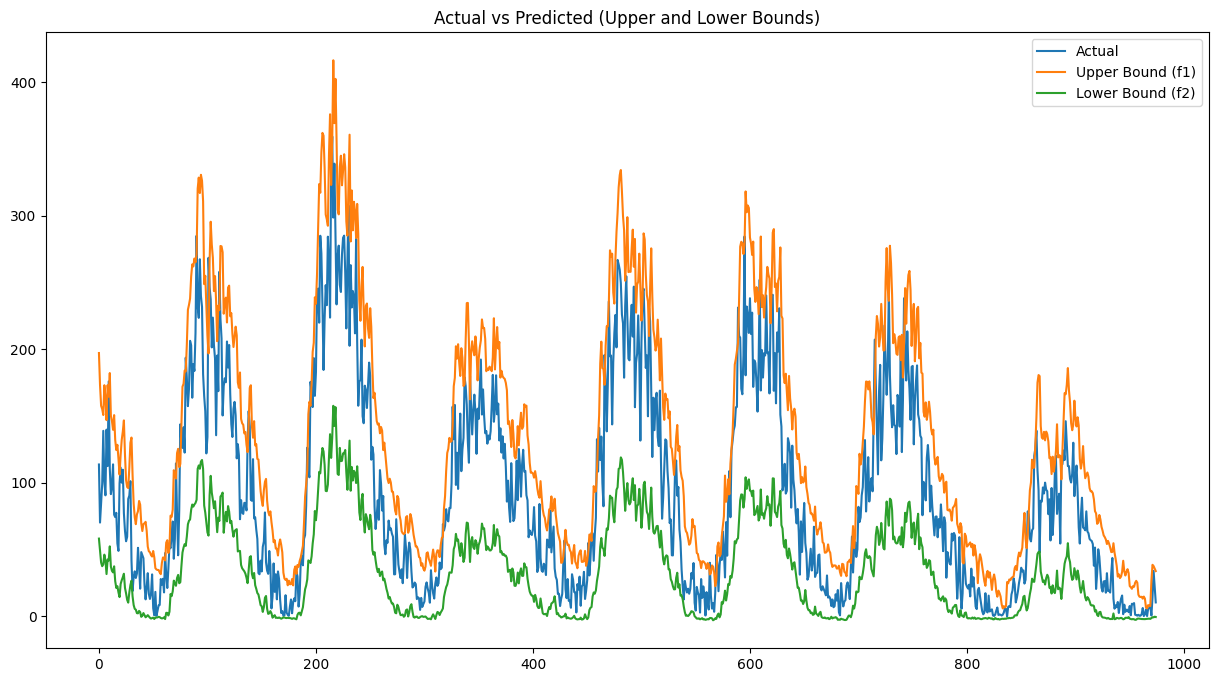

In [286]:
actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()
